## **EXP1 Predicting Missing Cell-Types from Bulks using Non-Negative Least Squares Regression Residual**

*This file includes EXP1 analysis and results. Files used were created in preprocessing/EXP1_pseudos notebook. The following file can be run independently, or as part of Papermill parametirized through EXP1.py*

**Summary:**
Increasing the number of missing celltypes, using random proportions pseudobulks. Then attempting to extract missing cell type information from residual. 

For the initial study, we used a single-nucleus RNA-seq dataset with 14 cell-types derived from adipose, and extracted the expression of five immune cell types (macrophage, T cell, B cell, monocyte, dendritic cell) with distinct expression. Pseudobulks were created for deconvolution by generating a random proportion vector, and defining the total number of cells per bulk as 5000. Cells were then sampled according to the random proportion vector for each cell type. The single-cell reference for deconvolution was constructed by normalizing the number of cell types to 10,000 for each type, sampled with replacement, resulting in a signature expression per cell type, per gene. We used this reference as having 0 missing cell types, and subsequently iteratively depleted the reference of 1, 2, 3, and 4 randomly chosen cell types to end with 5 distinct single-cell reference matrices: one with 0, 1, 2, 3, and 4 missing cell types compared to the pseudobulk.

**Hypothesis:**
Deleting cell types from NNLS reference will create a residual from which we can extract missing cell type information. 

**Deconv. Method:**
NNLS

**Factorization Methods:**
SVD, PCA, ICA, NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import sklearn as sk
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

These parameters are set in EXP1.py file.

In [2]:
#####################
### Set the study ###
#####################
# Paths:
res_name = f"MCT_snadp_EXP1"
pseudo_name = "MCT_snadp_EXP1_5CTnonoise"
files_path = "/../data/EXP1/"
cibersort_files = "/../data/EXP1/cibersort_results/snadp/MCT_snadp_EXP1_0_cibersort_sig.tsv"
noise_type = "5CTnonoise"
###### Set your random seed, num missing cells, and num_samples for reference and reproducibility
random_seed = 88
bulkprop_type = "random"
num_missing_cells = [0, 1, 2, 3]
num_bulks_total = 1000
num_samples = 10000

#if you want cells deleted to be chosen randomly:
cells_to_miss_random = False
cells_to_miss = {0: [], 1: [0], 2: [0, 3], 3: [0, 3, 4]}

# How to handle negative residual distribution for NMF
nmf_cut = "minimum_value"
#Environment
kernel_name = "env_ml"

In [3]:
#parameters into paths
actual_path = os.getcwd()
path = f"{actual_path}{files_path}"
aug_data_path = f"{actual_path}{files_path}"
cibersort_path = f"{actual_path}{cibersort_files}"
#Font name for plots
font = {'fontname':'Arial'}

# Import the previously processed datasets

*See preprocessing/EXP1_pseudos.ipynb notebook for details.*

In [4]:
#single cell as anndata object
adata_path = os.path.join(path, f"{res_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
Counter(sn_adata.obs["cell_types"])

Counter({'Mesothelial cell': 26276,
         'Fat cell': 24825,
         'Macrophage': 13625,
         'Preadipocyte': 26941,
         'Endothelial cell': 11480,
         'Endothelial cell of lymphatic vessel': 2339,
         'Pericyte cell': 1165,
         'T cell': 3022,
         'Smooth muscle cell': 2457,
         'B cell': 231,
         'Dendritic cell': 679,
         'Mast cell': 883,
         'Monocyte': 709,
         'Stromal cell of endometrium': 284,
         'Immature nk t cell': 1073,
         'Neutrophil': 77})

In [5]:
#excluding all cell types except 5 of interest
#if pseudos have 5 cell types
if pseudo_name == "MCT_snadp_EXP1_5CTnoise" or pseudo_name == "MCT_snadp_EXP1_5CTnonoise": 
    exclude = ['Preadipocyte',
        'Mesothelial cell',
        'Pericyte cell',
        'Fat cell',
        'Endothelial cell',
        'Endothelial cell of lymphatic vessel',
        'Smooth muscle cell',
        'Mast cell',
        'Immature nk t cell',
        'Stromal cell of endometrium',
        'Neutrophil']
    sn_adata = sn_adata[~sn_adata.obs["cell_types"].isin(exclude), :]
# ~ is “not”, so this reads like “var names that are not in exclude”
print(Counter(sn_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sn_adata.obs.cell_types.unique())
cell_order = sn_adata.obs.cell_types.unique()

Counter({'Macrophage': 13625, 'T cell': 3022, 'Monocyte': 709, 'Dendritic cell': 679, 'B cell': 231})


Randomly selecting cells to delete:

In [6]:
if cells_to_miss_random:
    cells_to_miss = sn_sc_preprocess.select_cells_missing(sn_adata, num_missing_cells, random_seed)
cells_to_miss    

{0: [], 1: [0], 2: [0, 3], 3: [0, 3, 4]}

## Creating Cell Reference nd Importing Bulks:


ref_raw is the sum of each gene expression per num_samples of each cell type. This is not scaled (raw). \
Once it is clipped and scaled with MinMax(), it becomes: ref_df, which is used in NNLS. 

In [7]:
# Making cell type reference without scaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var_names
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw = ref_raw.sort_index(axis=1) 
ref_raw

,B cell,Dendritic cell,Macrophage,Monocyte,T cell
A1BG,98.0,201.0,103.0,110.0,140.0
A1BG-AS1,390.0,637.0,384.0,382.0,312.0
A1CF,0.0,29.0,6.0,0.0,16.0
A2M,2400.0,8098.0,10431.0,2068.0,11672.0
A2M-AS1,290.0,126.0,95.0,81.0,1440.0
...,...,...,...,...,...
AL049555.1,0.0,0.0,0.0,0.0,0.0
AL109945.1,0.0,0.0,0.0,0.0,0.0
HIST1H3G,0.0,36.0,0.0,13.0,0.0
PAEP,0.0,0.0,4.0,0.0,0.0


In [8]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types.sort_values())
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types.sort_values())
ref_raw

,B cell,Dendritic cell,Macrophage,Monocyte,T cell
A1BG,98.0,201.0,103.0,110.0,140.0
A1BG-AS1,390.0,637.0,384.0,382.0,312.0
A1CF,0.0,29.0,6.0,0.0,16.0
A2M,2400.0,4463.0,4463.0,2068.0,4463.0
A2M-AS1,290.0,126.0,95.0,81.0,1440.0
...,...,...,...,...,...
AL049555.1,0.0,0.0,0.0,0.0,0.0
AL109945.1,0.0,0.0,0.0,0.0,0.0
HIST1H3G,0.0,36.0,0.0,13.0,0.0
PAEP,0.0,0.0,4.0,0.0,0.0


Importing Bulks:

In [9]:
#each pseudo file has:
## realisitc*200, cell_type_specific*1000*, random*200, equal*200
#so here we're defining the ranges to extract the bulks of choice.
bulk_range = dict()
bulk_range["realistic"] = range(0,200)
bulk_range["cell_type_specific"] = range(200,(50*num_cells)+200) #1000
bulk_range["random"] = range((50*num_cells)+200,(50*num_cells)+400) #1200
bulk_range["equal"] = range((50*num_cells)+400,(50*num_cells)+600) #1400
bulk_range["all"] = range(0,(50*num_cells)+600)

In [10]:
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

850

In [11]:
#importing bulks to deconvolve
X_full, Y_full, gene_df, meta_df = sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path, noise_type= f"{noise_type}_", file_name = res_name, num_bulks_training = num_bulks, num_files=10, random_selection=False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1
2
3
4
5
6
7
8
9


(8000, 2)
(8000, 2)


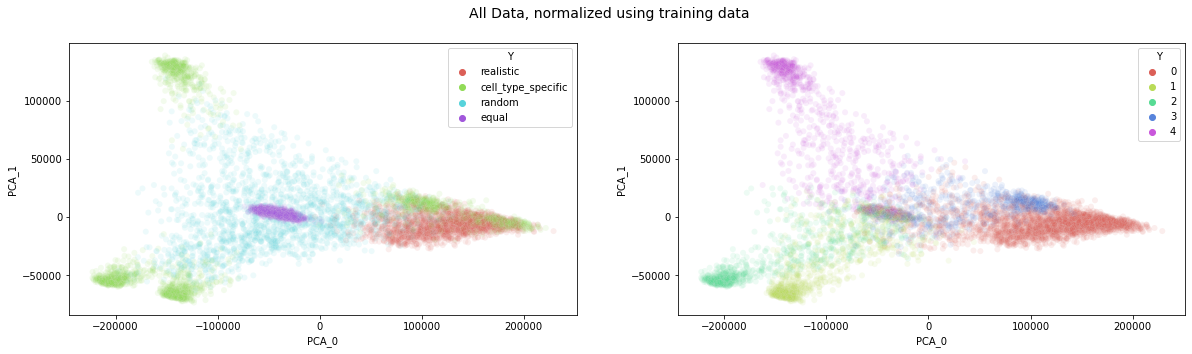

In [12]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 2, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[1], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

In [13]:
#cut to only the type of sample specific above.
idx_interest = np.where(meta_df.cell_prop_type == bulkprop_type)[0]
pseudo_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
prop_df.columns = vp.capitalize_first_letters(prop_df.columns)
prop_df = prop_df.sort_index(axis=1)
pseudo_df.index = range(0,len(pseudo_df))
prop_df.index = pseudo_df.index
pseudo_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,81.0,229.0,3.0,4354.0,74.0,37.0,268.0,18.0,30.0,3.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0
1,74.0,193.0,2.0,4109.0,266.0,31.0,193.0,8.0,49.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0
2,82.0,262.0,8.0,3958.0,150.0,46.0,234.0,10.0,53.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,1.0,0.0
3,64.0,181.0,6.0,4834.0,474.0,26.0,171.0,4.0,30.0,2.0,...,2.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0
4,80.0,243.0,7.0,4332.0,244.0,39.0,182.0,8.0,27.0,0.0,...,1.0,0.0,0.0,4.0,0.0,0.0,0.0,9.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,61.0,212.0,6.0,4413.0,279.0,43.0,222.0,11.0,47.0,0.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,5.0,0.0,0.0
1996,73.0,207.0,5.0,2814.0,98.0,50.0,228.0,12.0,46.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,4.0,0.0,0.0
1997,72.0,248.0,8.0,3533.0,135.0,44.0,181.0,20.0,27.0,1.0,...,0.0,0.0,0.0,5.0,2.0,0.0,0.0,5.0,0.0,0.0
1998,76.0,181.0,0.0,1524.0,93.0,46.0,155.0,6.0,75.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,1.0,0.0


In [14]:
#cutting to num_bulks number of pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudo_df.index, num_bulks_total, replace=False)
#cutting both props and pseudos
pseudo_df = pseudo_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudo_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
1059,86.0,276.0,13.0,4184.0,80.0,42.0,259.0,19.0,26.0,0.0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,12.0,1.0,0.0
929,52.0,175.0,7.0,3072.0,133.0,44.0,207.0,8.0,50.0,1.0,...,0.0,0.0,0.0,1.0,5.0,0.0,0.0,3.0,3.0,0.0
1506,73.0,218.0,9.0,3759.0,201.0,32.0,237.0,14.0,48.0,1.0,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,3.0,1.0,0.0
237,52.0,224.0,1.0,2063.0,173.0,31.0,165.0,2.0,62.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1371,49.0,213.0,0.0,2059.0,145.0,20.0,147.0,3.0,79.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,50.0,184.0,4.0,2884.0,204.0,43.0,177.0,12.0,77.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1132,54.0,195.0,2.0,4063.0,160.0,43.0,256.0,9.0,54.0,1.0,...,1.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,4.0,0.0
1998,76.0,181.0,0.0,1524.0,93.0,46.0,155.0,6.0,75.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,1.0,0.0
1988,71.0,228.0,9.0,3297.0,149.0,24.0,150.0,14.0,51.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0


In [15]:
#clippign before scaling to 95th pecentile
pseudo_copy = pseudo_df.copy() #keeping genes
pseudo_df = pseudo_df.values #np array
clip_upper = np.quantile(pseudo_df, 0.95)
pseudo_df = np.clip(pseudo_df, 0, clip_upper)
#and normalize to values between 0 and 1
scaler = MinMaxScaler()
scaler.fit(pseudo_df)
normalized_pseudo_df = scaler.transform(pseudo_df)
normalized_pseudo_df = pd.DataFrame(normalized_pseudo_df, 
                            columns = pseudo_copy.columns, index= pseudo_copy.index)
normalized_pseudo_df      

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
1059,0.710526,0.688442,0.684211,1.000000,0.067434,0.530303,0.601533,0.633333,0.080808,0.00,...,0.000,0.0,0.0,0.777778,0.0,0.0,0.0,0.60,0.25,0.0
929,0.263158,0.180905,0.368421,1.000000,0.154605,0.560606,0.402299,0.266667,0.323232,0.25,...,0.000,0.0,0.0,0.111111,0.5,0.0,0.0,0.15,0.75,0.0
1506,0.539474,0.396985,0.473684,1.000000,0.266447,0.378788,0.517241,0.466667,0.303030,0.25,...,0.000,0.0,0.0,0.111111,0.3,0.0,0.0,0.15,0.25,0.0
237,0.263158,0.427136,0.052632,0.804142,0.220395,0.363636,0.241379,0.066667,0.444444,0.00,...,0.000,0.0,0.0,0.111111,0.0,0.0,0.0,0.05,0.25,0.0
1371,0.223684,0.371859,0.000000,0.800690,0.174342,0.196970,0.172414,0.100000,0.616162,0.25,...,0.000,0.0,0.0,0.111111,0.0,0.0,0.0,0.05,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,0.236842,0.226131,0.210526,1.000000,0.271382,0.545455,0.287356,0.400000,0.595960,0.00,...,0.000,0.0,0.0,0.111111,0.0,0.0,0.0,0.05,0.00,0.0
1132,0.289474,0.281407,0.105263,1.000000,0.199013,0.545455,0.590038,0.300000,0.363636,0.25,...,0.125,0.0,0.0,0.000000,0.4,0.0,0.0,0.10,1.00,0.0
1998,0.578947,0.211055,0.000000,0.339085,0.088816,0.590909,0.203065,0.200000,0.575758,0.00,...,0.000,0.0,0.0,0.000000,0.3,0.0,0.0,0.15,0.25,0.0
1988,0.513158,0.447236,0.473684,1.000000,0.180921,0.257576,0.183908,0.466667,0.333333,0.00,...,0.000,0.0,0.0,0.111111,0.0,0.0,0.0,0.20,0.00,0.0


In [16]:
# read in cibersort barcode genes 
cibersort_df = pd.read_csv(cibersort_path, sep="\t")
cibersort_genes = cibersort_df["NAME"].values.tolist()
#and set intersection of gene_ids and cibersort:
gene_notin = np.setdiff1d(gene_ids, cibersort_genes)
#keep genes in both and check number
gene_ids = [ele for ele in gene_ids if ele not in gene_notin]
len(gene_ids)     

997

In [17]:
#cutting to cibersort barcode genes 
pseudo_copy  = pseudo_copy[gene_ids]
ref_raw = ref_raw.loc[gene_ids,:]
ref_df = ref_df.loc[gene_ids,:]
normalized_pseudo_df = normalized_pseudo_df[gene_ids]
normalized_pseudo_df

gene_ids,A2M,AAMDC,AATBC,ABCA10,ABCA5,ABCA6,ABCA8,ABCA9,ABCB10,ABCB4,...,GORASP2,GPALPP1,GPAT3,GPAT4,GPATCH11,GPC6,GPI,GPM6A,GPR132,GPR137B
1059,1.000000,0.842412,0.190667,0.304598,0.321678,1.0,0.591133,1.000000,0.824219,0.262335,...,0.141593,0.813239,1.000000,0.950339,0.793689,0.440397,0.873754,0.028638,0.878092,1.000000
929,1.000000,0.412451,0.376000,0.218391,0.249750,1.0,0.435140,1.000000,0.574219,0.220217,...,0.601770,0.536643,0.229654,0.679458,0.334951,0.285872,0.564784,0.361972,0.560071,0.961611
1506,1.000000,0.447471,0.137333,0.215517,0.443556,1.0,0.341544,1.000000,0.380859,0.288809,...,0.544248,0.654846,0.386342,0.478555,0.480583,0.291391,0.558140,0.411268,0.530035,0.862177
237,0.804142,0.233463,0.080000,0.670977,0.745255,1.0,0.223317,0.452669,0.156250,0.774970,...,0.407080,0.160757,0.204864,0.374718,0.638350,0.831126,0.219269,1.000000,0.349823,0.220264
1371,0.800690,0.301556,0.145333,0.755747,0.821179,1.0,0.100164,0.547331,0.201172,0.728039,...,0.787611,0.174941,0.139850,0.469526,0.500000,0.477925,0.252492,1.000000,0.243816,0.276274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,1.000000,0.301556,0.253333,0.439655,0.566434,1.0,0.311987,0.765836,0.511719,0.436823,...,0.783186,0.385343,0.276894,0.528217,0.339806,0.353201,0.541528,0.724413,0.340989,0.419132
1132,1.000000,0.605058,0.236000,0.222701,0.339660,1.0,0.655172,1.000000,0.402344,0.216606,...,0.606195,0.657210,0.217961,0.686230,0.393204,0.238411,0.558140,0.315962,0.507067,1.000000
1998,0.339085,0.071984,0.445333,0.570402,0.534466,1.0,0.147783,0.550890,0.392578,0.592058,...,0.553097,0.401891,0.206735,0.553047,0.359223,0.561810,0.448505,0.889671,0.356890,0.370044
1988,1.000000,0.521401,0.146667,0.482759,0.530470,1.0,0.339901,0.745196,0.560547,0.432010,...,0.225664,0.460993,0.872311,0.661400,0.750000,0.636865,0.471761,0.453521,0.606007,0.429830


TSNEs of Pseuboulks and References: We expect the point of the References (cells) to be in separated within the pseudobulks encoding.

===> Finding 180 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.89 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.19 seconds
===> Running optimization with exaggeration=1.00, lr=1000.00 for 500 iterations...
Iteration   50, KL divergence 0.8041, 50 iterations in 0.5840 sec
Iteration  100, KL divergence 0.7889, 50 iterations in 0.4132 sec
Iteration  150, KL divergence 0.7853, 50 iterations in 0.4134 sec
Iteration  200, KL divergence 0.7837, 50 iterations in 0.4130 sec
Iteration  250, KL divergence 0.7824, 50 iterations in 0.4134 sec
Iteration  300, KL divergence 0.7812, 50 iterations in 0.4139 sec
Iteration  350, KL divergence 0.7807, 50 iterations in 0.4136 sec
Iteration  400, KL divergence 0.7798, 50 iterations in 0.4132 sec
Iteration  450, KL divergence 0.7795, 50 iterations in 0.4137 sec
Iteration  500, KL divergence 0.7802, 50 iterations in 0.4137 sec
   --> Time elapsed: 4.31 seconds
===> Finding 15 nearest n

Perplexity value 60 is too high. Using perplexity 1.33 instead


Iteration   50, KL divergence 9001.5015, 50 iterations in 0.2131 sec
Iteration  100, KL divergence 8970.3859, 50 iterations in 0.0241 sec
Iteration  150, KL divergence 8957.4487, 50 iterations in 0.0241 sec
Iteration  200, KL divergence 8951.2318, 50 iterations in 0.0241 sec
Iteration  250, KL divergence 8947.2900, 50 iterations in 0.0242 sec
   --> Time elapsed: 0.31 seconds
===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 18.5470, 50 iterations in 0.0092 sec
Iteration  100, KL divergence 18.2480, 50 iterations in 0.0141 sec
Iteration  150, KL divergence 17.9562, 50 iterations in 0.0089 sec
Iteration  200, KL divergence 17.8

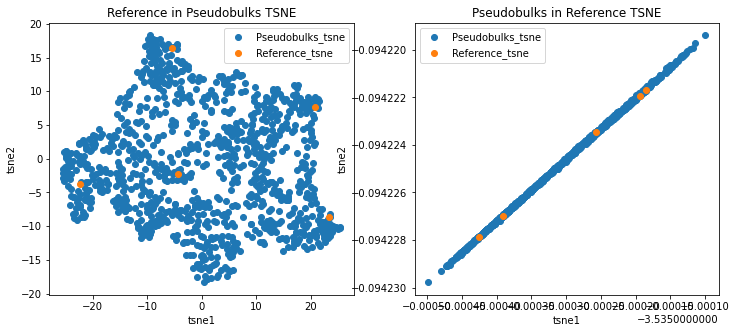

In [18]:
#tsne plots of reference dataframes projected in normalized pseudobulks TSNE 
#figures
plt.figure(figsize=(12, 5))
#data used
x_train = normalized_pseudo_df.values
x_test = ref_df.T.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 1)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Pseudobulks_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Reference_tsne" )
plt.title(f"Reference in Pseudobulks TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
#data used (switching)
x_train = ref_df.T.values
x_test = normalized_pseudo_df.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 2)
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Pseudobulks_tsne" )
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Reference_tsne" )
plt.title(f"Pseudobulks in Reference TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
plt.show()

#Each cell in the reference should be far apart.

In [19]:
all_refs = dict()
all_prop_refs = dict()
all_prop_refs_rebalanced = dict()
all_refs_raw = dict()
all_refs_av = dict()
#with no cell missing is just ref_df
all_refs[0] = ref_df.copy()
all_refs_raw[0] = ref_raw.copy()
all_prop_refs[0] = prop_df.copy()
all_prop_refs_rebalanced[0] = prop_df.copy()

#Assigning the rest in a loop
for num in num_missing_cells[1:]:
    #dropping cell types missing from references
    all_refs[num] = ref_df.drop(ref_df.columns[cells_to_miss[num]], axis=1)
    all_refs_raw[num] = ref_raw.drop(ref_raw.columns[cells_to_miss[num]], axis=1)
    all_prop_refs[num] = prop_df.drop(prop_df.columns[cells_to_miss[num]], axis=1) 
    all_prop_refs[num]= all_prop_refs[num].sort_index(axis=1)
    all_prop_refs_rebalanced[num] = all_prop_refs[num]
    all_prop_refs_rebalanced[num] = all_prop_refs_rebalanced[num].sort_index(axis=1)
    for idx,sample in all_prop_refs_rebalanced[num].iterrows():
        tot = np.sum(sample) #making them equal 1
        sample = sample / tot

## NNLS Deconvolution:

In [20]:
calc_prop_tot, calc_res_tot, custom_res_tot, comparison_prop_tot, missing_cell_tot  = vp.calc_nnls(all_refs, prop_df, normalized_pseudo_df, num_missing_cells, cells_to_miss)

Exp 0
Exp 1
Exp 2
Exp 3


# Evalutating NNLS Performance:

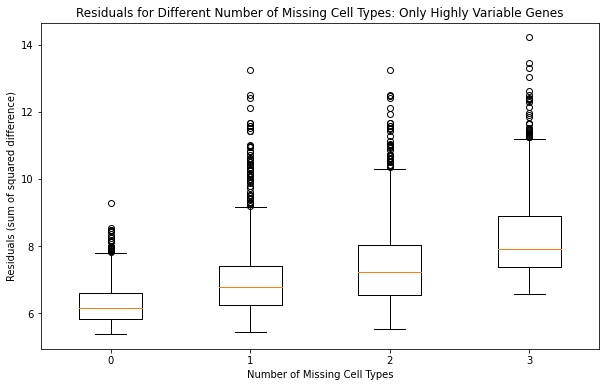

In [21]:
#Distribution of residuals as the sum of squared difference from NNLS
residuals = [calc_res_tot[exp] for exp in num_missing_cells]

plt.figure(figsize=(10, 6))
plt.boxplot(residuals, labels=num_missing_cells)
plt.xlabel('Number of Missing Cell Types')
plt.ylabel('Residuals (sum of squared difference)')
plt.title('Residuals for Different Number of Missing Cell Types: Only Highly Variable Genes')
plt.show()

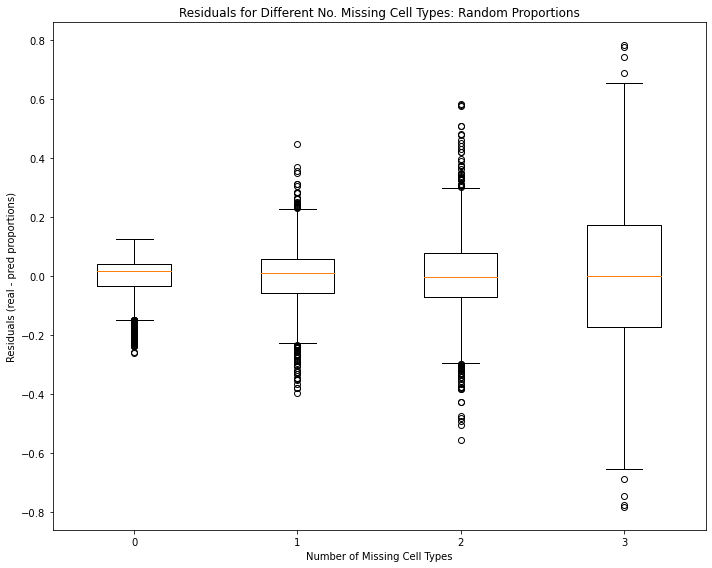

In [22]:
#Distribution of residuals as the difference between calculated and real proportions.
fig, ax = plt.subplots(figsize=(10, 8))

# List to store all the residual values
residual_values = []

# Iterate over the dataframes and extract the residual values
for num_cells in num_missing_cells:
    df = custom_res_tot[num_cells]
    residuals = df.values.flatten()  # Flatten the dataframe to a 1D array
    residual_values.append(residuals)

# Plot the box and whisker plot for all the residuals
ax.boxplot(residual_values, labels=num_missing_cells)
ax.set_title("Residuals for Different No. Missing Cell Types: Random Proportions")
ax.set_xlabel("Number of Missing Cell Types")
ax.set_ylabel("Residuals (real - pred proportions)")

plt.tight_layout()
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


{'Monocyte', 'T cell', 'Dendritic cell', 'B cell', 'Macrophage'}
Index(['B cell', 'Dendritic cell', 'Macrophage', 'Monocyte', 'T cell'], dtype='object')
CategoricalIndex(['B cell', 'Dendritic cell', 'Macrophage', 'Monocyte',
                  'T cell'],
                 categories=['B cell', 'Dendritic cell', 'Macrophage', 'Monocyte', 'T cell'], ordered=False, dtype='category')
Index(['B cell', 'Dendritic cell', 'Macrophage', 'Monocyte', 'T cell'], dtype='object')
['B cell', 'Dendritic cell', 'Macrophage', 'Monocyte', 'T cell']
Real Proportions shape: (1000, 5)
Estimated Proportions shape: (1000, 5)


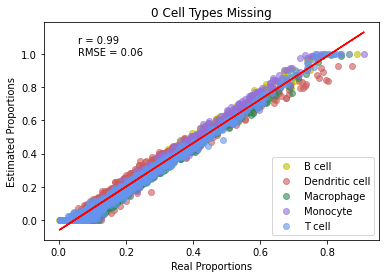

Index(['Dendritic cell', 'Macrophage', 'Monocyte', 'T cell'], dtype='object')
CategoricalIndex(['Dendritic cell', 'Macrophage', 'Monocyte', 'T cell'], categories=['B cell', 'Dendritic cell', 'Macrophage', 'Monocyte', 'T cell'], ordered=False, dtype='category')
Index(['Dendritic cell', 'Macrophage', 'Monocyte', 'T cell'], dtype='object')
['Dendritic cell', 'Macrophage', 'Monocyte', 'T cell']
Real Proportions shape: (1000, 4)
Estimated Proportions shape: (1000, 4)


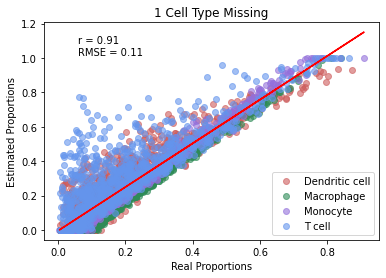

Index(['Dendritic cell', 'Macrophage', 'T cell'], dtype='object')
CategoricalIndex(['Dendritic cell', 'Macrophage', 'T cell'], categories=['B cell', 'Dendritic cell', 'Macrophage', 'Monocyte', 'T cell'], ordered=False, dtype='category')
Index(['Dendritic cell', 'Macrophage', 'T cell'], dtype='object')
['Dendritic cell', 'Macrophage', 'T cell']
Real Proportions shape: (1000, 3)
Estimated Proportions shape: (1000, 3)


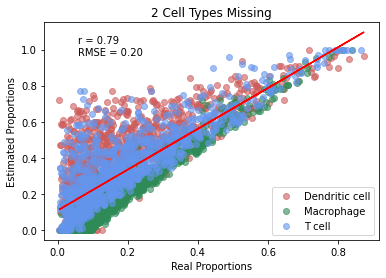

Index(['Dendritic cell', 'Macrophage'], dtype='object')
CategoricalIndex(['Dendritic cell', 'Macrophage'], categories=['B cell', 'Dendritic cell', 'Macrophage', 'Monocyte', 'T cell'], ordered=False, dtype='category')
Index(['Dendritic cell', 'Macrophage'], dtype='object')
['Dendritic cell', 'Macrophage']
Real Proportions shape: (1000, 2)
Estimated Proportions shape: (1000, 2)


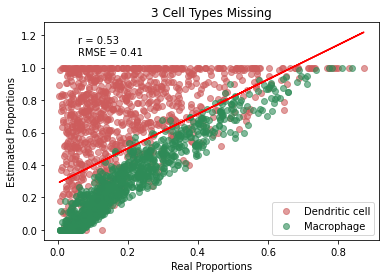

In [23]:
# Collecting all unique cell types across num_missing_cells
custom_colors = [ 'mediumpurple','cornflowerblue', 'indianred','y', 'seagreen', 'darkorange']
all_cell_types = set()
for num in num_missing_cells:
    all_cell_types.update(all_prop_refs[num].columns.tolist())

print(all_cell_types)

# Creating a fixed color mapping for all cell types
color_map = {cell_type: custom_colors[i % len(custom_colors)] for i, cell_type in enumerate(all_cell_types)}

for num in num_missing_cells:
    
    real_proportions = all_prop_refs_rebalanced[num].values.astype(float)
    estimated_proportions = calc_prop_tot[num].values.astype(float)
    cell_types = all_prop_refs[num].columns.tolist()

    print(all_prop_refs_rebalanced[num].columns)
    print(calc_prop_tot[num].columns)
    print(all_prop_refs[num].columns)
    print(cell_types)

    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    
    # Scatter plot
    fig, ax = plt.subplots()
    for cell_type in cell_types:
        x = real_proportions[:, cell_types.index(cell_type)]
        y = estimated_proportions[:, cell_types.index(cell_type)]
        
        # Use the fixed color mapping
        color = color_map[cell_type]
        
        ax.scatter(x, y, label=cell_type, color=color, alpha=0.6)
    
    
    # Fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")
    
    # Calculate r
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    
    # Calculate RMSE
    rmse = np.sqrt(((real_proportions - estimated_proportions) ** 2).mean())
    
    # And annotate
    plt.annotate(f'r = {r:.2f}\nRMSE = {rmse:.2f}', xy=(0.1, 0.85), xycoords='axes fraction')
    
    plt.xlabel('Real Proportions', **font)
    plt.ylabel('Estimated Proportions', **font)
    if num == 1:
        plt.title(f'{num} Cell Type Missing', **font)
    else:    
        plt.title(f'{num} Cell Types Missing', **font)

    plt.legend(loc='lower right')  # show the cell type labels in the legend
    plt.show()


## **Recreated Matrices and Extracting Missing Cell Information**

Multiplying the reference and calculated proportions:

In [24]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
recreated_mat_all = dict()
for num in num_missing_cells:
        recreated_mat_all[num] = pd.DataFrame(all_refs[num] @ calc_prop_tot[num].T)
        recreated_mat_all[num] = recreated_mat_all[num].T
        recreated_mat_all[num].columns = gene_ids
recreated_mat_all[0]    

,A2M,AAMDC,AATBC,ABCA10,ABCA5,ABCA6,ABCA8,ABCA9,ABCB10,ABCB4,...,GORASP2,GPALPP1,GPAT3,GPAT4,GPATCH11,GPC6,GPI,GPM6A,GPR132,GPR137B
0,1.000000,0.450921,0.059763,0.320019,0.416940,0.988373,0.423992,0.978710,0.364810,0.105761,...,0.238179,0.358302,0.761681,0.333242,0.289142,0.322310,0.324308,0.070184,0.389772,0.952235
1,0.712851,0.340370,0.138773,0.353276,0.411055,0.845714,0.368615,0.674577,0.333837,0.109208,...,0.285254,0.340231,0.260276,0.279329,0.179368,0.349021,0.318471,0.270332,0.305516,0.702955
2,0.878878,0.380185,0.037407,0.370878,0.513918,0.824526,0.385015,0.714211,0.292112,0.139710,...,0.270704,0.314089,0.314815,0.254992,0.221528,0.358399,0.293442,0.287019,0.301910,0.678059
3,0.600476,0.313022,0.018820,0.571541,0.741230,0.688011,0.299543,0.467833,0.219157,0.386431,...,0.291280,0.222464,0.170741,0.215584,0.252920,0.598921,0.273365,0.874010,0.242502,0.359746
4,0.560999,0.297375,0.042783,0.557510,0.709394,0.679382,0.297724,0.436814,0.223950,0.362616,...,0.299242,0.230697,0.089994,0.212406,0.227531,0.581321,0.276596,0.855720,0.234165,0.350234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.662867,0.299575,0.097832,0.451406,0.586590,0.721552,0.296953,0.496679,0.285689,0.213416,...,0.279181,0.267651,0.258810,0.237202,0.202369,0.448440,0.292509,0.495942,0.259665,0.472581
996,0.829197,0.388610,0.065915,0.340666,0.425308,0.876228,0.424975,0.769592,0.303676,0.113507,...,0.288892,0.351010,0.185915,0.269463,0.194865,0.335094,0.306815,0.273153,0.312995,0.761802
997,0.503338,0.264331,0.168916,0.475750,0.553372,0.724453,0.268424,0.444256,0.309440,0.239211,...,0.288405,0.270228,0.255870,0.255290,0.188328,0.488048,0.309387,0.577458,0.259882,0.451717
998,0.841090,0.386040,0.060855,0.423041,0.555152,0.861045,0.347986,0.758246,0.322692,0.213258,...,0.247659,0.295029,0.646809,0.293710,0.284534,0.433343,0.306969,0.351902,0.335440,0.704938


Missing Cell Information:

In [25]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
for num in num_missing_cells[1:]:
    missing_cell_prop[num] = prop_df[missing_cell_tot[num].columns]  

## **Calculate Residuals:**

Residual uses:

Pseudobulks - [Calculated_Proportions * Reference]

In [26]:
#Residual as the the difference between the recreated matrix and pseudobulks.
residuals = dict()
for num in num_missing_cells:
    res = normalized_pseudo_df.values - recreated_mat_all[num].values
    residuals[num] = pd.DataFrame(res, columns = gene_ids)
residuals[0]    

,A2M,AAMDC,AATBC,ABCA10,ABCA5,ABCA6,ABCA8,ABCA9,ABCB10,ABCB4,...,GORASP2,GPALPP1,GPAT3,GPAT4,GPATCH11,GPC6,GPI,GPM6A,GPR132,GPR137B
0,1.110223e-16,0.391492,0.130903,-0.015421,-0.095261,0.011627,0.167141,0.021290,0.459408,0.156574,...,-0.096586,0.454937,0.238319,0.617096,0.504547,0.118088,0.549446,-0.041545,0.488320,0.047765
1,2.871487e-01,0.072081,0.237227,-0.134886,-0.161305,0.154286,0.066525,0.325423,0.240382,0.111009,...,0.316516,0.196412,-0.030622,0.400129,0.155583,-0.063149,0.246313,0.091640,0.254555,0.258656
2,1.211224e-01,0.067285,0.099927,-0.155361,-0.070362,0.175474,-0.043472,0.285789,0.088747,0.149098,...,0.273544,0.340757,0.071527,0.223563,0.259055,-0.067008,0.264697,0.124248,0.228125,0.184118
3,2.036654e-01,-0.079559,0.061180,0.099436,0.004025,0.311989,-0.076226,-0.015164,-0.062907,0.388539,...,0.115800,-0.061707,0.034123,0.159134,0.385429,0.232205,-0.054096,0.125990,0.107322,-0.139482
4,2.396916e-01,0.004182,0.102551,0.198237,0.111785,0.320618,-0.197559,0.110517,-0.022778,0.365423,...,0.488368,-0.055756,0.049856,0.257120,0.272469,-0.103396,-0.024105,0.144280,0.009651,-0.073960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.371329e-01,0.001981,0.155502,-0.011751,-0.020156,0.278448,0.015034,0.269158,0.226030,0.223407,...,0.504005,0.117692,0.018084,0.291015,0.137437,-0.095239,0.249020,0.228471,0.081324,-0.053450
996,1.708032e-01,0.216448,0.170085,-0.117965,-0.085648,0.123772,0.230197,0.230408,0.098668,0.103100,...,0.317303,0.306201,0.032046,0.416768,0.198339,-0.096683,0.251324,0.042809,0.194073,0.238198
997,-1.642524e-01,-0.192346,0.276418,0.094652,-0.018907,0.275547,-0.120640,0.106633,0.083138,0.352847,...,0.264692,0.131663,-0.049134,0.297758,0.170896,0.073762,0.139118,0.312213,0.097008,-0.081673
998,1.589096e-01,0.135361,0.085811,0.059718,-0.024683,0.138955,-0.008085,-0.013050,0.237855,0.218752,...,-0.021995,0.165964,0.225502,0.367690,0.465466,0.203523,0.164792,0.101619,0.270567,-0.275108


## **Singular Value Decomposition**

SVD on each residual matrix. For this purposes, we will only focus on U and S.

U: Left singular vectors, representing the column space of the original matrix. (cells)

Σ or sigma: Singular values, representing the diagonal matrix of singular values.

Vh or V^T: Right singular vectors, representing the row space of the original matrix. (sample)

Calculating SVD

In [27]:
num_cells_missing = num_missing_cells #for each number of missing cells
num_celltypes = len(sn_adata.obs['cell_types'].unique())

In [28]:
# SVD on residual 1
U_all = dict()
s_all = dict()
V_all = dict()
Matres_all = dict()

for num in num_cells_missing:
    df = residuals[num]
    Mat = df.astype("float32")
    U, s, V = sp.linalg.svd(Mat)
    U = pd.DataFrame(U)
    s = pd.DataFrame(s)
    V = pd.DataFrame(V)

    U_all[num] = U
    s_all[num] = s
    V_all[num] = V
    Matres_all[num] = Mat

S-Value Eval for each SVD:

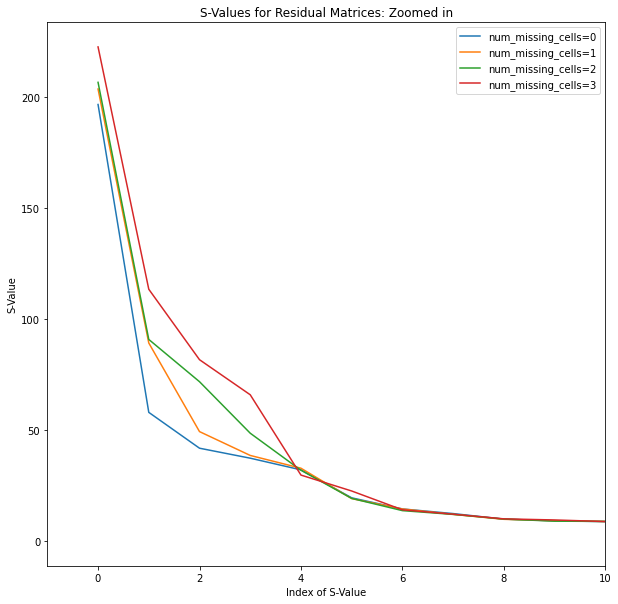

In [29]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating num 
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)
# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Residual Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

**Reconstructing Residual Matrix**

In [30]:
#reconstructing SVD using all only some S values, Residual 1.
Recon_Mat_matchS = dict()
for num in num_cells_missing:
    num_SVs = num + 1 #num of comp
    #cutting S and U to 30 to match elbow plots
    U = U_all[num].values[:, :num_SVs]
    S = np.zeros((U.shape[1], Matres_all[num].shape[0]))
    diag_val = s_all[num].values[:num_SVs]
    np.fill_diagonal(S, [diag_val])
    anum = U @ S #reconstructing
    #saving to df dict
    Recon_Mat_matchS[num] = pd.DataFrame(anum[:,0:num_SVs])

**Plotting Correlations between SVD on Residual and Missing Cell Information:**

**Residual** 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


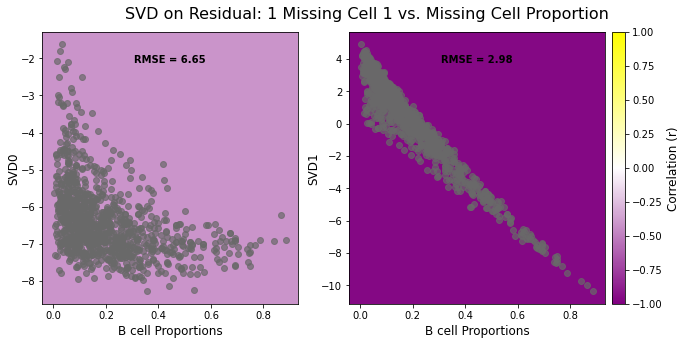

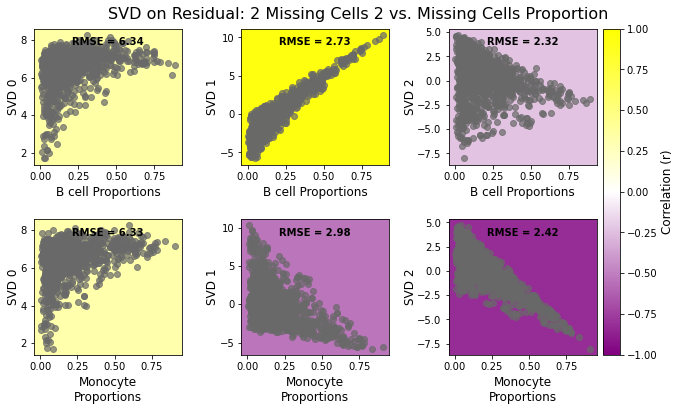

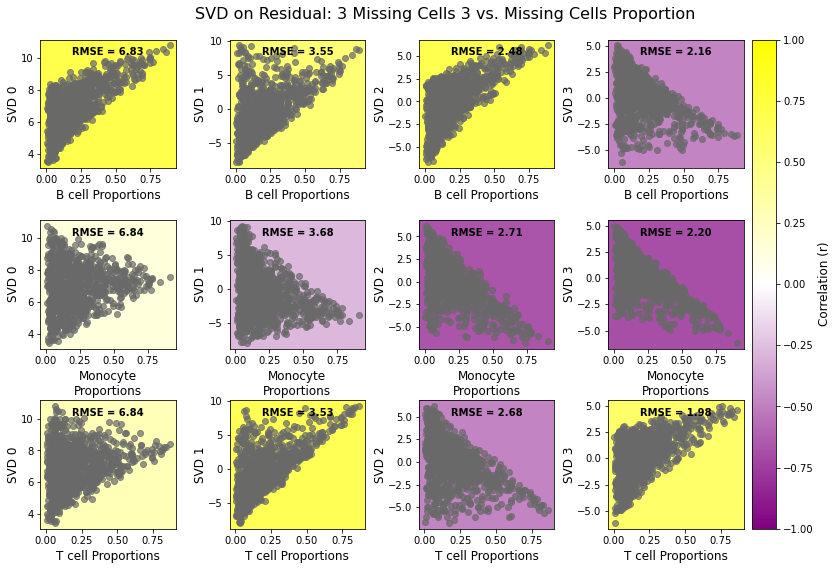

In [31]:
#SVD Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
vp.factors_vs_proportions_rmse(Recon_Mat_matchS, missing_cell_prop, num_missing_cells, "SVD") 
#Each missing cell's expression * proportion matrix is projected into the SVD's reconstructed matrix (just S * U).        

## **PCA**

Calculating PCA for each Residual and Percent of Variance Explained

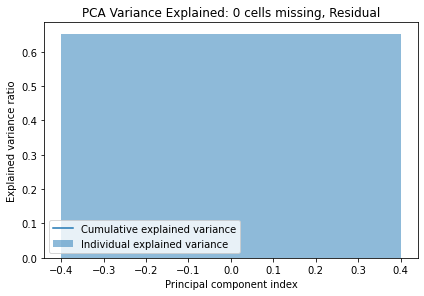

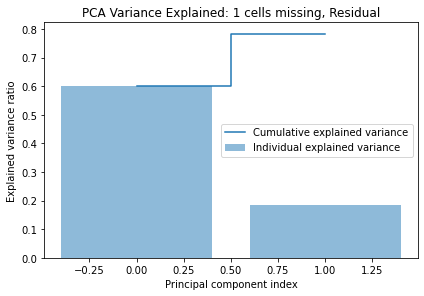

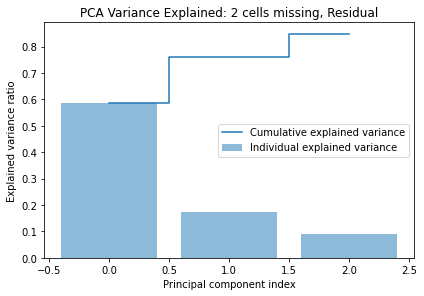

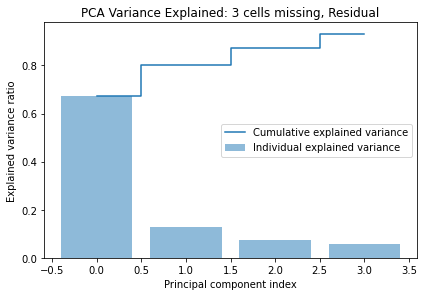

In [32]:
pca_res = dict()
for num in num_cells_missing:
    df = residuals[num].T #transposing to get length of genes instead of samples
    fit = PCA(n_components= num + 1)
    pca_results = fit.fit_transform(df.values)

    exp_var_pca = fit.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    ## plot variance explained
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title(f"PCA Variance Explained: {num} cells missing, Residual")
    plt.show()
    pca_res[num] = pd.DataFrame(pca_results)

Analyzing PCA Results

Residual

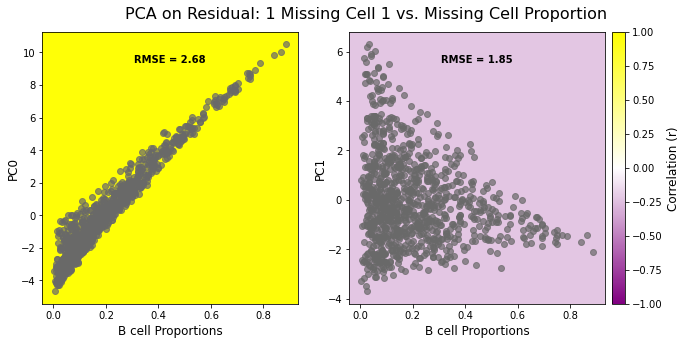

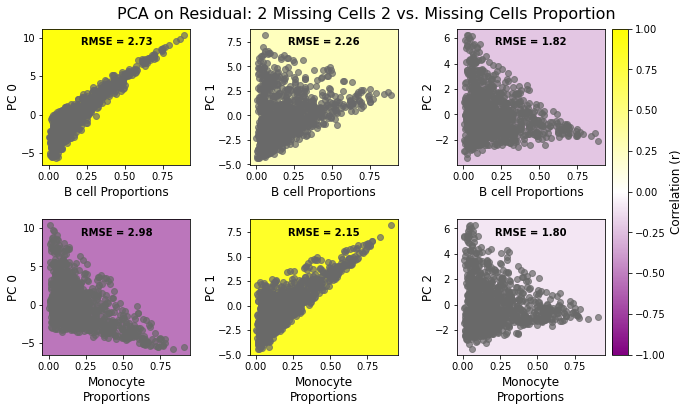

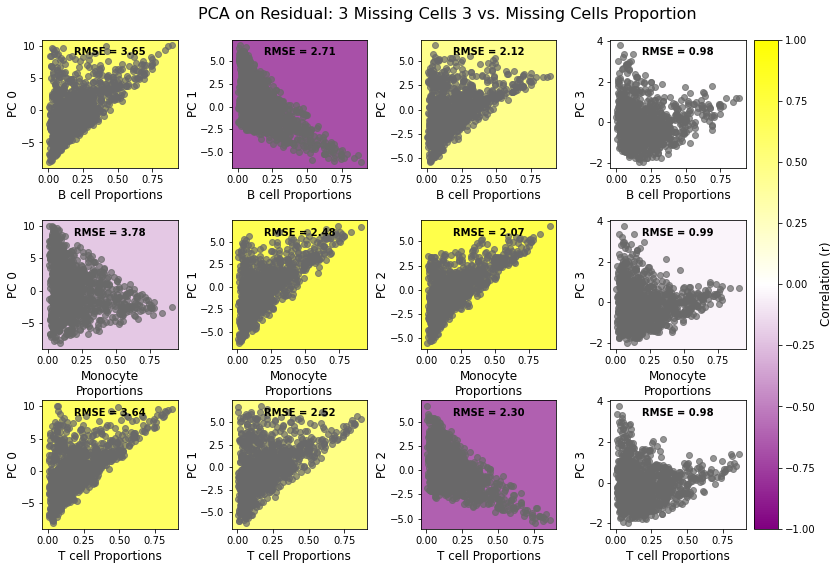

In [33]:
#PCA Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_pca_sample = dict()
for num in num_missing_cells[1:]:
    num_pca = num + 1
    pca = PCA(n_components = num_pca)
    res_pca_df = pca.fit_transform(residuals[num])
    res_pca_sample[num] = pd.DataFrame(res_pca_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_rmse(res_pca_sample, missing_cell_prop, num_cells_missing, "PCA")

## **ICA**

Calculate ICA

In [34]:
#ICA on residual 1
res_ica = dict()
for num in num_missing_cells:
    num_ica = num + 1
    ica = FastICA(n_components = num_ica)
    res_ica_df = ica.fit_transform(residuals[num].T)
    res_ica_df = pd.DataFrame(res_ica_df)
    res_ica[num] = res_ica_df

Residual

/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


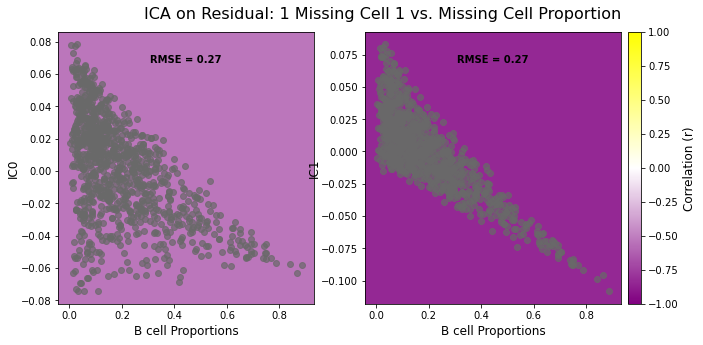

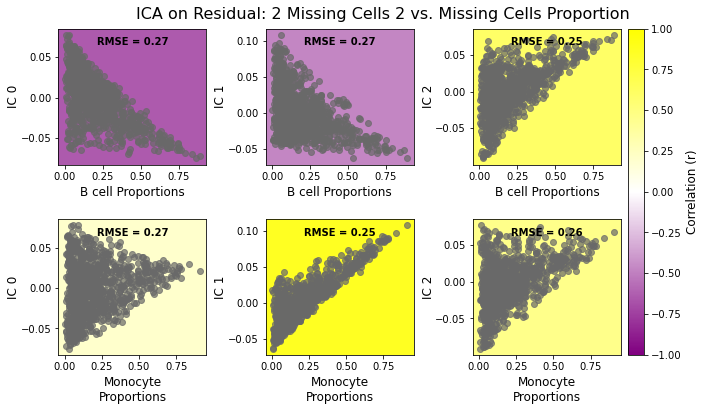

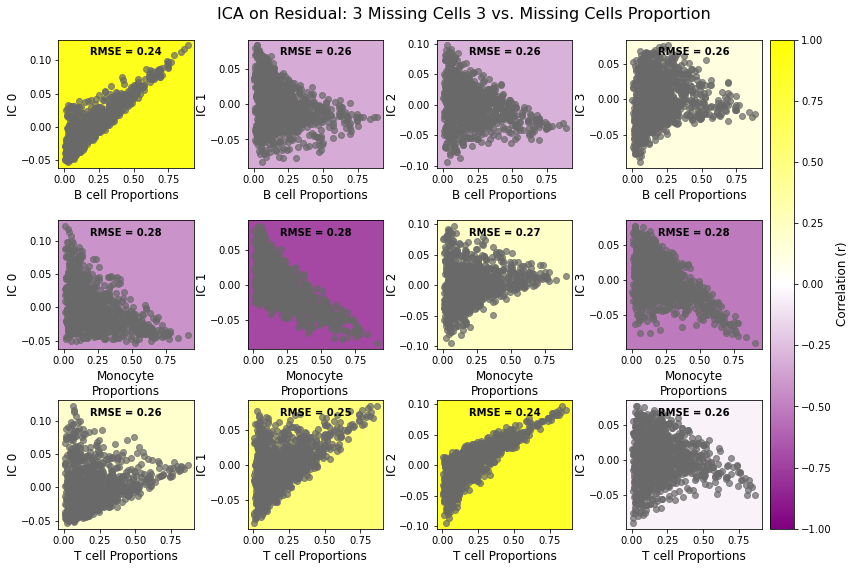

In [35]:
#ICA Residual (by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_ICA_sample = dict()
for num in num_missing_cells[1:]:
    num_ICA = num + 1
    ica = FastICA(n_components = num_ICA)
    res_ICA_df = ica.fit_transform(residuals[num])
    res_ICA_sample[num] = pd.DataFrame(res_ICA_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_rmse(res_ICA_sample, missing_cell_prop, num_cells_missing, "ICA")

## NMF

Analyzing how close to negative the distributions of each residual are:

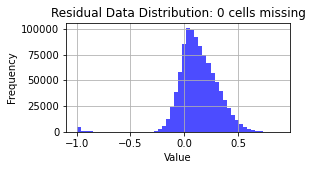

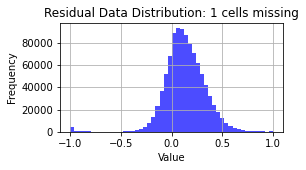

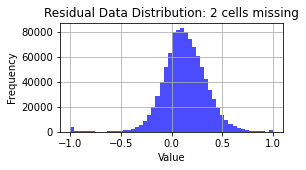

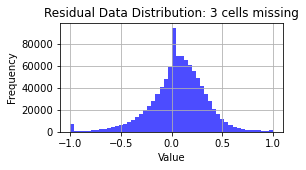

In [36]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

1.0000000000000002


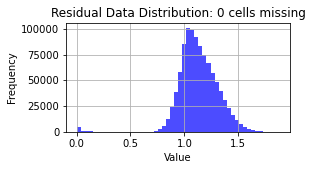

1.0000000000000002


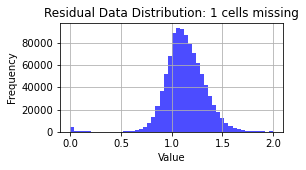

1.0000000000000002


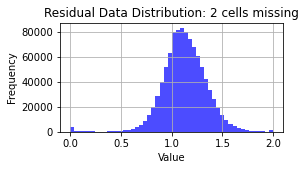

1.0000000000000002


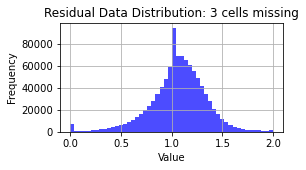

In [37]:
#shifting distribution of residuals to do NMF
residuals_shift = residuals
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### Analyzing NMF Results:

Now comparing the Residual Scaled (with pseudobulks and reference MinMax scaled) and the Residual (not scaled, all matrices as used in deconvolution). We can see the impact of scaling in our ability to recover the missing cell type's proportions.

Residual

/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


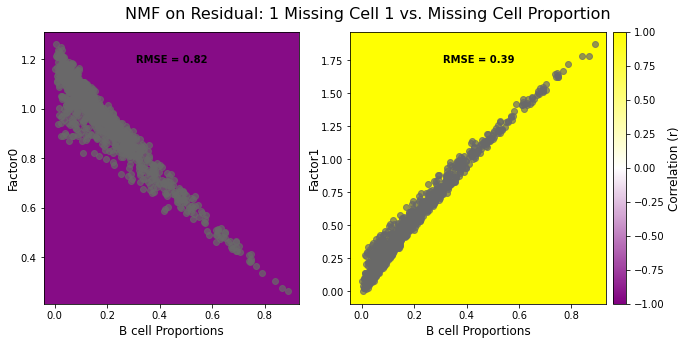

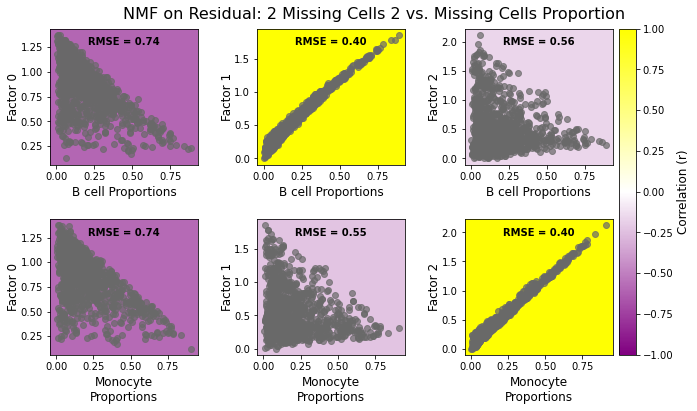

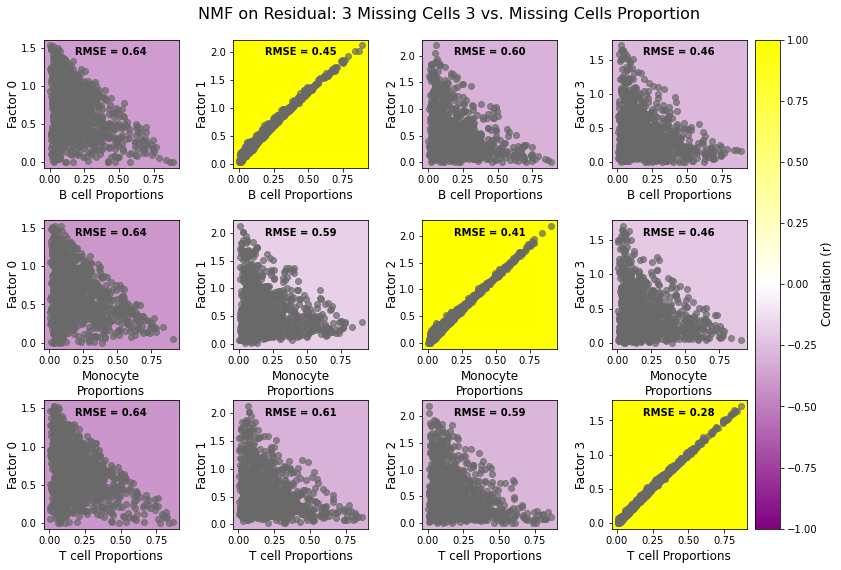

In [38]:
#NMF Residual(by sample) compared to each missing celltype proportion
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 10000, init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

Same as above, but now making the NMF components be in the same scale (0 to 1).

/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


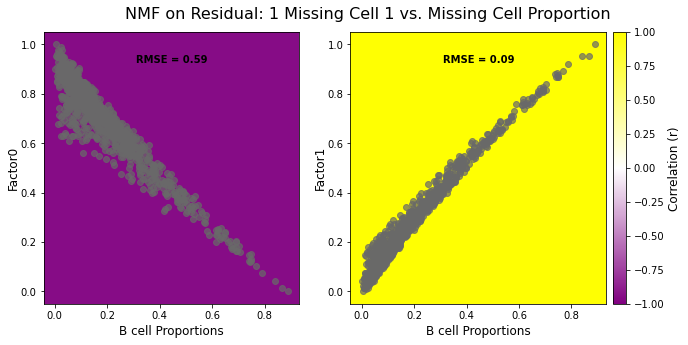

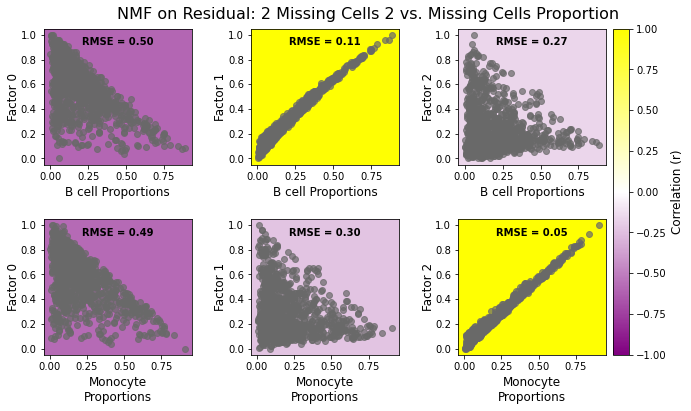

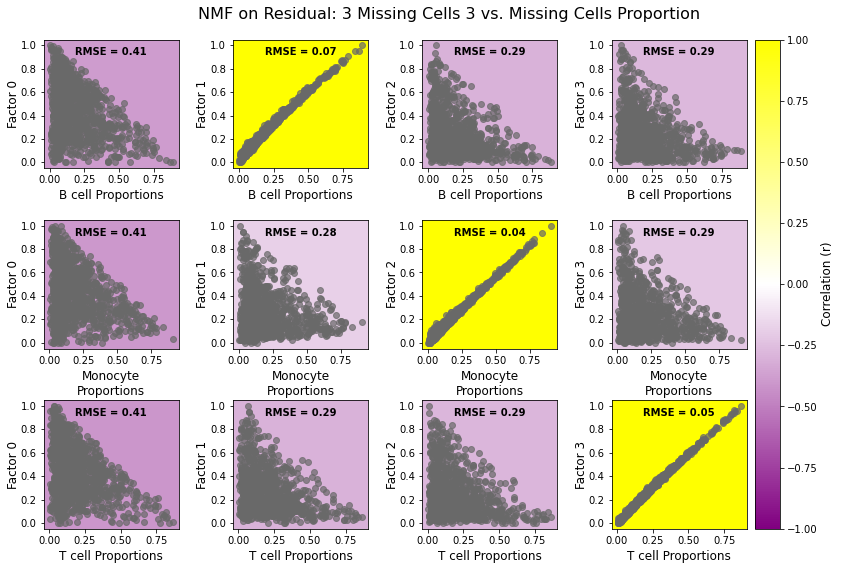

In [39]:
#NMF Residual(by sample) compared to each missing celltype proportion
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 10000 ,init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
    #putting each component between 0 and 1 to match proportion range
    pseudo_raw_val = res_nmf_df.values 
    scaler = MinMaxScaler()
    scaler.fit(pseudo_raw_val)
    pseudo_scale = scaler.transform(pseudo_raw_val)
    res_nmf[num] = pd.DataFrame(pseudo_scale)
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

### Now we check how much variance is explained by each component

1 missing cell:

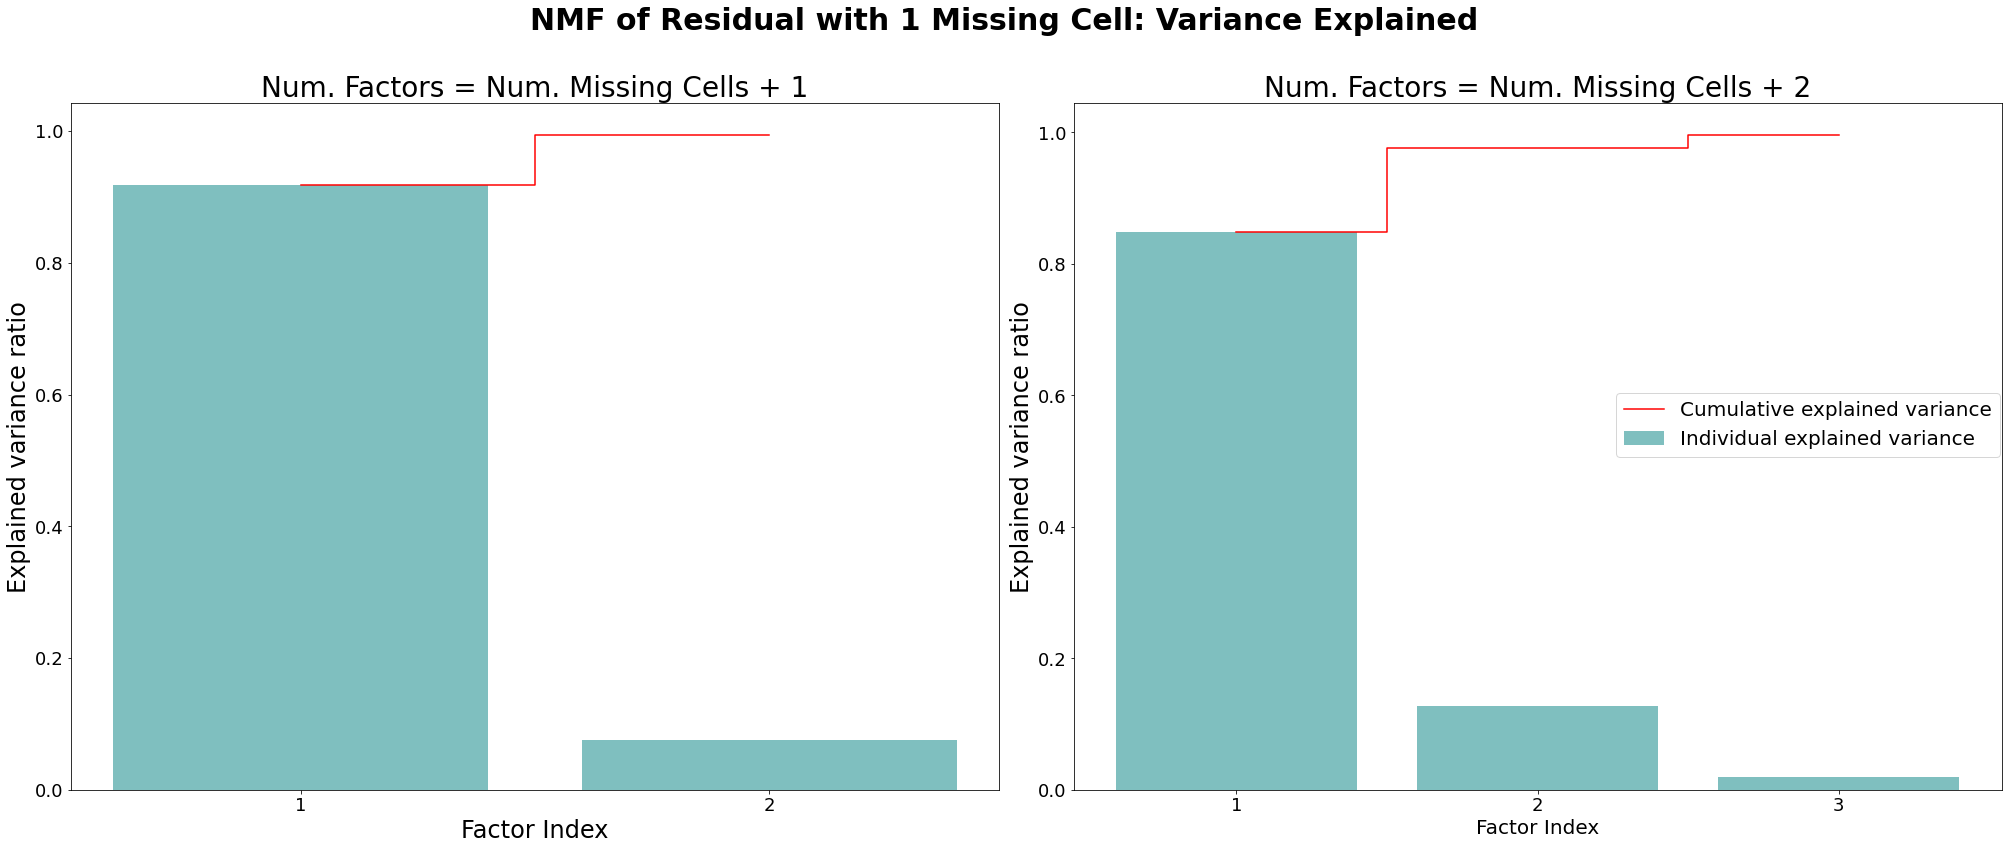

In [85]:
# Create a figure with 2 subplots (axes)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 12))

### First Experiment: NMF with 2 components ###
num_nmf_comp_combo = 2
nmf = NMF(n_components=num_nmf_comp_combo, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_shift[1])
res_nmf_combo = pd.DataFrame(res_nmf_df)
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids

V = residuals_shift[1].values
W = res_nmf_combo.values
H = components_combo.values

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum1 = explained_variance
indiv_variance1 = [cum_sum1[0], cum_sum1[1] - cum_sum1[0]]

# First plot
axes[0].bar(range(0, len(indiv_variance1)), indiv_variance1, alpha=0.5, align='center', label='Individual explained variance', color='teal')
axes[0].step(range(0, len(cum_sum1)), cum_sum1, where='mid', label='Cumulative explained variance', color='red')
axes[0].set_ylabel('Explained variance ratio', fontsize=24)
axes[0].set_xlabel('Factor Index', fontsize=24)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['1', '2'], fontsize=24)
axes[0].set_title('Num. Factors = Num. Missing Cells + 1', fontsize=28)

### Second Experiment: NMF with 3 components ###
num_nmf_comp_combo = 3
nmf = NMF(n_components=num_nmf_comp_combo, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_shift[1])
res_nmf_combo = pd.DataFrame(res_nmf_df)
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids

V = residuals_shift[1].values
W = res_nmf_combo.values
H = components_combo.values

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum2 = explained_variance
indiv_variance2 = [cum_sum2[0], cum_sum2[1] - cum_sum2[0], cum_sum2[2] - cum_sum2[1]]

# Second plot
axes[1].bar(range(0, len(indiv_variance2)), indiv_variance2, alpha=0.5, align='center', label='Individual explained variance', color='teal')
axes[1].step(range(0, len(cum_sum2)), cum_sum2, where='mid', label='Cumulative explained variance', color='red')
axes[1].set_ylabel('Explained variance ratio', fontsize=24)
axes[1].set_xlabel('Factor Index', fontsize=20)
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['1', '2', '3'], fontsize=18)
axes[1].set_title('Num. Factors = Num. Missing Cells + 2', fontsize=28)

# Add a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=18)  # Adjusts both x and y ticks
axes[1].tick_params(axis='both', which='major', labelsize=18)

# Main title for the entire figure
fig.suptitle('NMF of Residual with 1 Missing Cell: Variance Explained', fontweight='bold', fontsize=30)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the main title
plt.show()


2 missing cells:

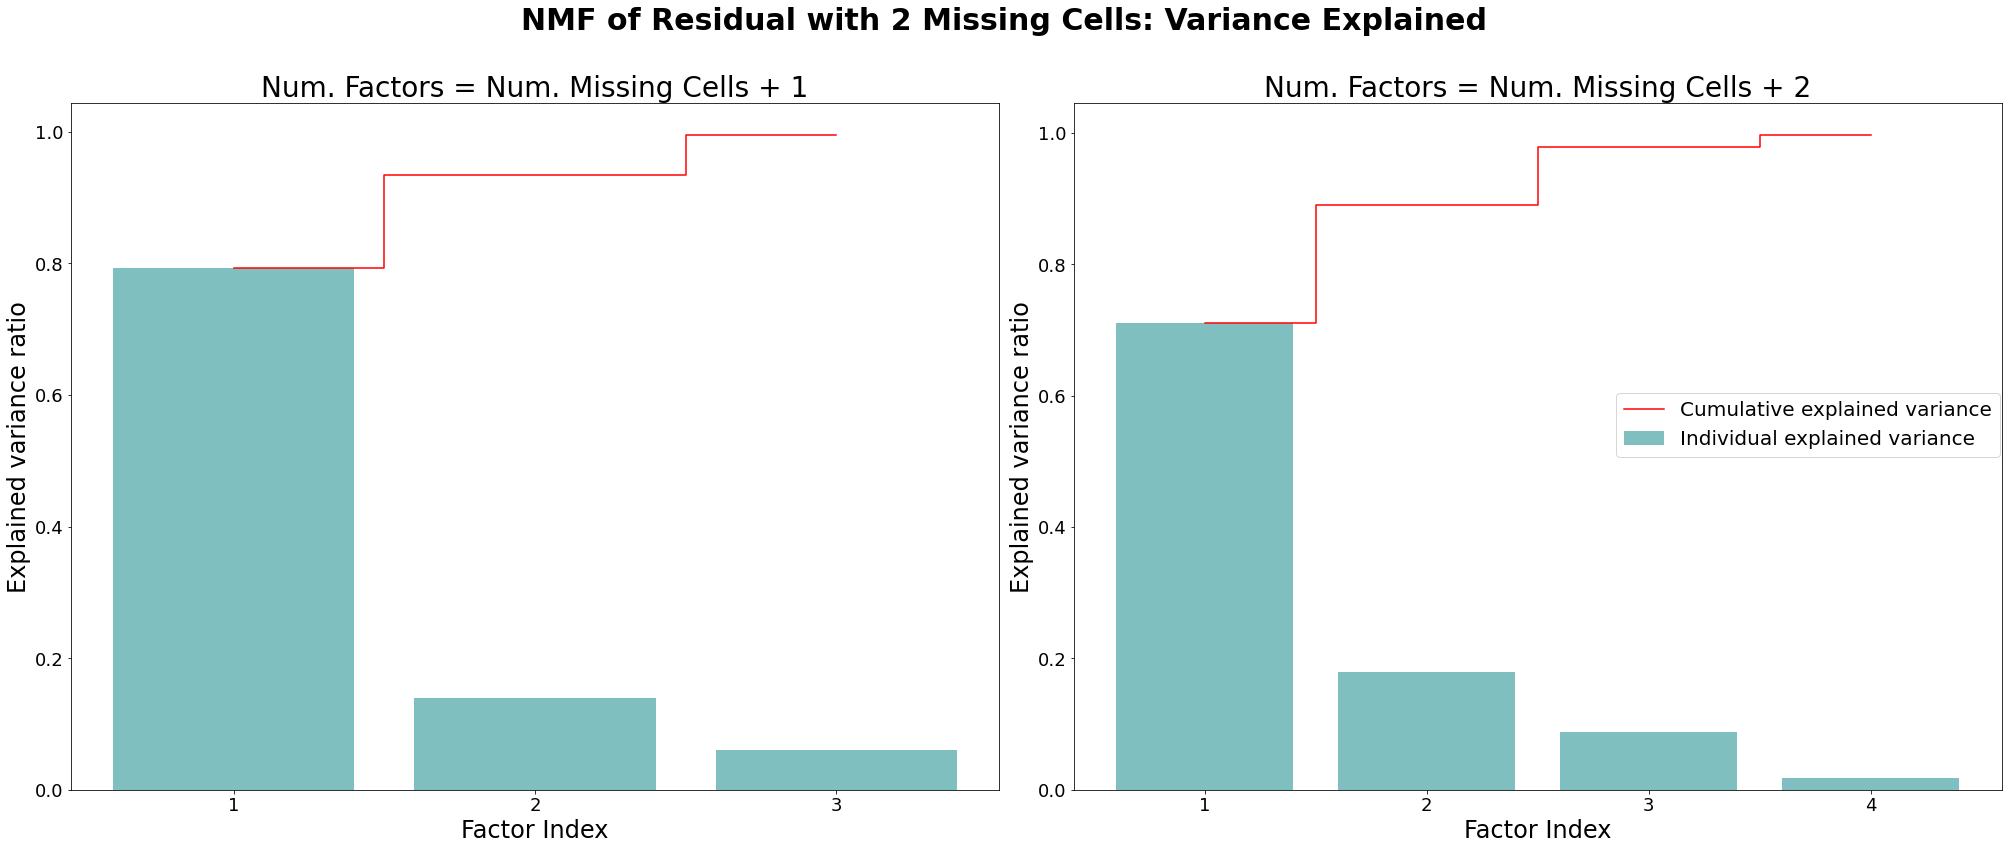

In [84]:
# Create a figure with 2 subplots (axes)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 12))

### First Experiment: NMF with 3 components ###
num_nmf_comp_combo = 3
nmf = NMF(n_components=num_nmf_comp_combo, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_shift[2])
res_nmf_combo = pd.DataFrame(res_nmf_df)
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids

V = residuals_shift[2].values
W = res_nmf_combo.values
H = components_combo.values

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum1 = explained_variance
indiv_variance1 = [cum_sum1[0], cum_sum1[1] - cum_sum1[0], cum_sum1[2] - cum_sum1[1]]

# First plot
axes[0].bar(range(0, len(indiv_variance1)), indiv_variance1, alpha=0.5, align='center', label='Individual explained variance', color='teal')
axes[0].step(range(0, len(cum_sum1)), cum_sum1, where='mid', label='Cumulative explained variance', color='red')
axes[0].set_ylabel('Explained variance ratio', fontsize=24)
axes[0].set_xlabel('Factor Index', fontsize=24)
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['1', '2', '3'], fontsize=24)
axes[0].set_title('Num. Factors = Num. Missing Cells + 1', fontsize=28)

### Second Experiment: NMF with 4 components ###
num_nmf_comp_combo = 4
nmf = NMF(n_components=num_nmf_comp_combo, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_shift[2])
res_nmf_combo = pd.DataFrame(res_nmf_df)
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids

V = residuals_shift[2].values
W = res_nmf_combo.values
H = components_combo.values

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum2 = explained_variance
indiv_variance2 = [cum_sum2[0], cum_sum2[1] - cum_sum2[0], cum_sum2[2] - cum_sum2[1], cum_sum2[3] - cum_sum2[2]]

# Second plot
axes[1].bar(range(0, len(indiv_variance2)), indiv_variance2, alpha=0.5, align='center', label='Individual explained variance', color='teal')
axes[1].step(range(0, len(cum_sum2)), cum_sum2, where='mid', label='Cumulative explained variance', color='red')
axes[1].set_ylabel('Explained variance ratio', fontsize=24)
axes[1].set_xlabel('Factor Index', fontsize=24)
axes[1].set_xticks([0, 1, 2, 3])
axes[1].set_xticklabels(['1', '2', '3', '4'], fontsize=24)
axes[1].set_title('Num. Factors = Num. Missing Cells + 2', fontsize=28)

# Add a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=18)  # Adjusts both x and y ticks
axes[1].tick_params(axis='both', which='major', labelsize=18)

# Main title for the entire figure
fig.suptitle('NMF of Residual with 2 Missing Cells: Variance Explained', fontweight='bold', fontsize=30)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the main title
plt.show()


3 missing cells:

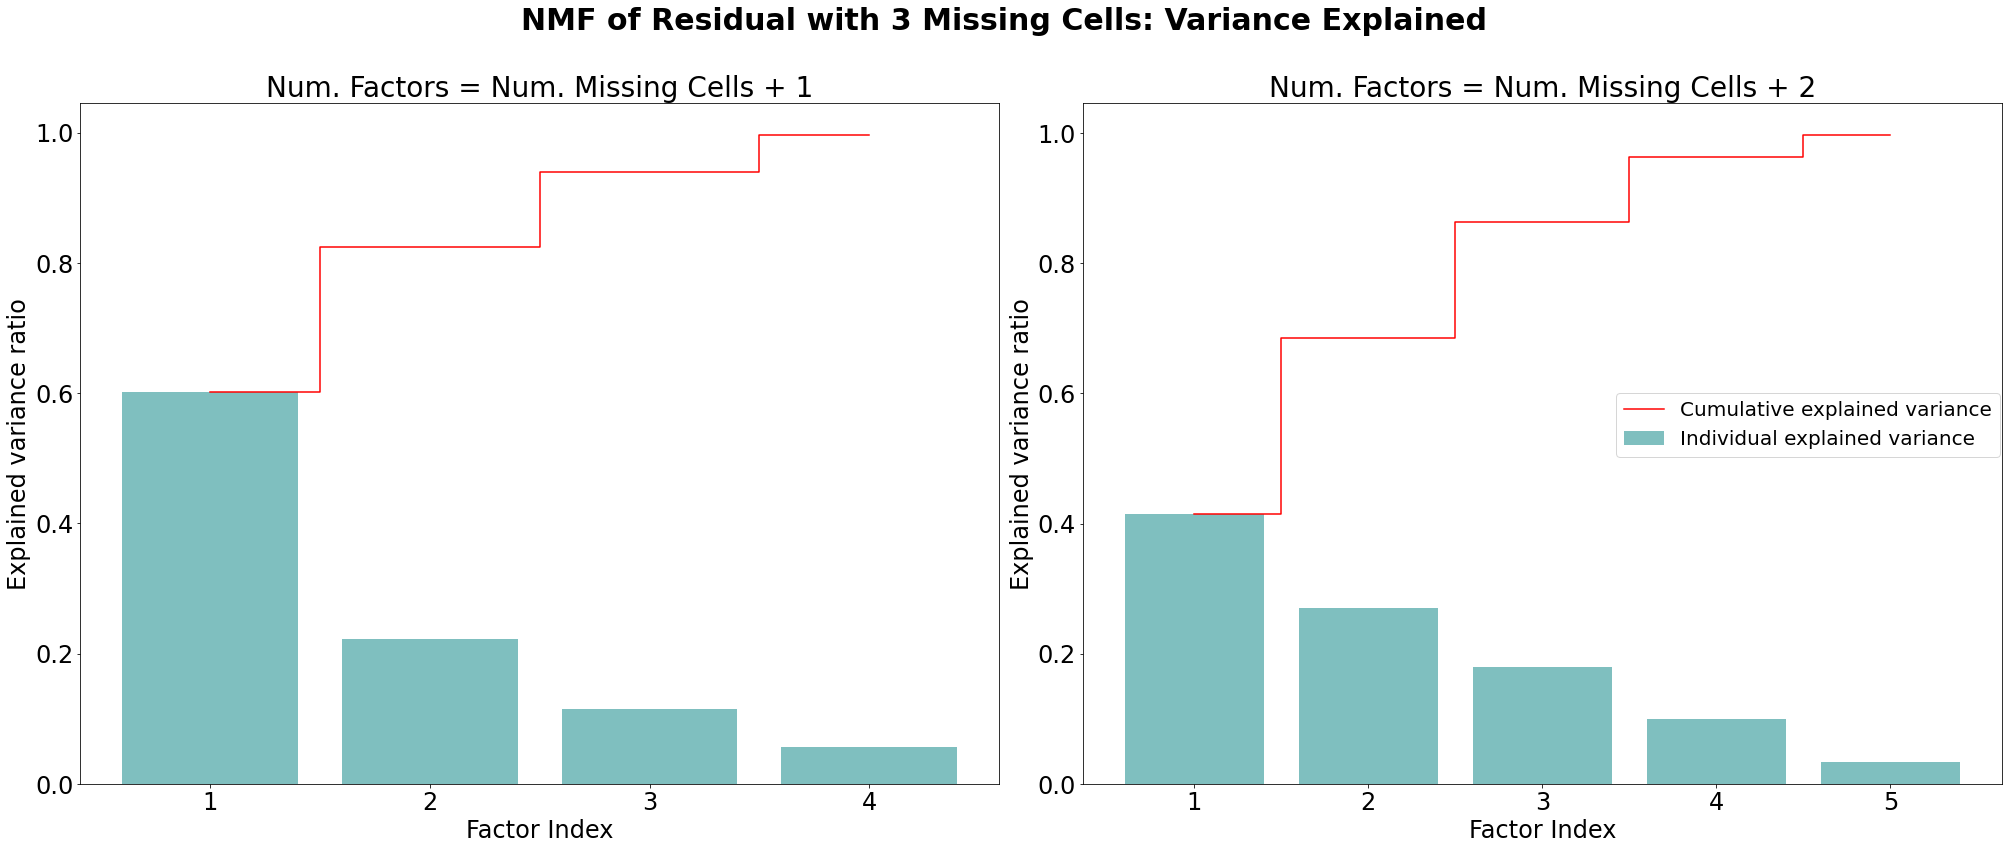

In [83]:
# Create a figure with 2 subplots (axes)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 12))

### First Experiment: NMF with 4 components ###
num_nmf_comp_combo = 4
nmf = NMF(n_components=num_nmf_comp_combo, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_shift[3])
res_nmf_combo = pd.DataFrame(res_nmf_df)
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids

V = residuals_shift[3].values
W = res_nmf_combo.values
H = components_combo.values

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum1 = explained_variance
indiv_variance1 = [cum_sum1[0], cum_sum1[1] - cum_sum1[0], cum_sum1[2] - cum_sum1[1], cum_sum1[3] - cum_sum1[2]]

# First plot
axes[0].bar(range(0, len(indiv_variance1)), indiv_variance1, alpha=0.5, align='center', label='Individual explained variance', color='teal')
axes[0].step(range(0, len(cum_sum1)), cum_sum1, where='mid', label='Cumulative explained variance', color='red')
axes[0].set_ylabel('Explained variance ratio', fontsize=24)
axes[0].set_xlabel('Factor Index', fontsize=24)
axes[0].set_xticks([0, 1, 2, 3])
axes[0].set_xticklabels(['1', '2', '3', '4'], fontsize=24)
axes[0].tick_params(axis='both', which='major', labelsize=24)
axes[0].set_title('Num. Factors = Num. Missing Cells + 1', fontsize=28)

### Second Experiment: NMF with 5 components ###
num_nmf_comp_combo = 5
nmf = NMF(n_components=num_nmf_comp_combo, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_shift[3])
res_nmf_combo = pd.DataFrame(res_nmf_df)
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids

V = residuals_shift[3].values
W = res_nmf_combo.values
H = components_combo.values

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum2 = explained_variance
indiv_variance2 = [cum_sum2[0], cum_sum2[1] - cum_sum2[0], cum_sum2[2] - cum_sum2[1], cum_sum2[3] - cum_sum2[2], cum_sum2[4] - cum_sum2[3]]

# Second plot
axes[1].bar(range(0, len(indiv_variance2)), indiv_variance2, alpha=0.5, align='center', label='Individual explained variance', color='teal')
axes[1].step(range(0, len(cum_sum2)), cum_sum2, where='mid', label='Cumulative explained variance', color='red')
axes[1].set_ylabel('Explained variance ratio', fontsize=24)
axes[1].set_xlabel('Factor Index', fontsize=24)
axes[1].set_xticks([0, 1, 2, 3, 4])
axes[1].set_xticklabels(['1', '2', '3', '4', '5'], fontsize=24)
axes[1].tick_params(axis='both', which='major', labelsize=24)
axes[1].set_title('Num. Factors = Num. Missing Cells + 2', fontsize=28)

# Add a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', fontsize=20)

# Main title for the entire figure
fig.suptitle('NMF of Residual with 3 Missing Cells: Variance Explained', fontweight='bold', fontsize=30)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the main title
plt.show()
